In [29]:
import tensorflow as tf
# Disable eager execution (required for LIME)
tf.compat.v1.disable_eager_execution()
from tensorflow.keras import backend as K

# Custom F1 Score metric
def f1_score(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2 * (precision * recall) / (precision + recall + K.epsilon())
    return f1_val

# Load the saved model
loaded_model = tf.keras.models.load_model('final_model-60.h5', custom_objects={'f1_score': f1_score})

# Display the model's architecture
loaded_model.summary()


2023-10-18 15:24:40.931679: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-10-18 15:24:41.158006: W tensorflow/c/c_api.cc:304] Operation '{name:'conv4_block2_3_bn_4/moving_variance/Assign' id:24921 op device:{requested: '', assigned: ''} def:{{{node conv4_block2_3_bn_4/moving_variance/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](conv4_block2_3_bn_4/moving_variance, conv4_block2_3_bn_4/moving_variance/Initializer/ones)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-10-18 15:24:41.487911: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-10-18 15:24:42.331031: I tensorflow/core/grappler/optimizers

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

2023-10-18 15:24:44.245083: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


  0%|          | 0/1000 [00:00<?, ?it/s]

/Users/senu2k/anaconda3/envs/flaskenvnew/lib/python3.9/site-packages/keras/src/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
2023-10-18 15:24:44.853767: W tensorflow/c/c_api.cc:304] Operation '{name:'dense_5_4/Softmax' id:27122 op device:{requested: '', assigned: ''} def:{{{node dense_5_4/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_5_4/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-10-18 15:24:45.191643: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


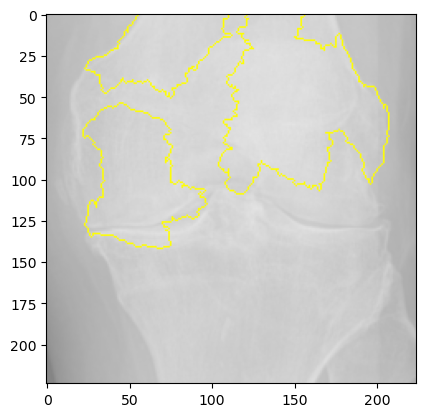

Explanation for label 4:
Area: 6, Importance: 0.06018699215755504
Area: 5, Importance: 0.035642784185186266
Area: 10, Importance: 0.03336928310054366
Area: 18, Importance: -0.030307059548146283
Area: 11, Importance: 0.02764712864279142
Area: 8, Importance: -0.027007413868035367
Area: 14, Importance: 0.025998080088646153
Area: 13, Importance: 0.024025133547784155
Area: 27, Importance: -0.021438575008125692
Area: 4, Importance: 0.020776822159640294
Area: 3, Importance: 0.020581059826186174
Area: 1, Importance: 0.01714722053433541
Area: 12, Importance: 0.014972415218897025
Area: 24, Importance: 0.013582578041941618
Area: 7, Importance: -0.012903150911405417
Area: 29, Importance: 0.01258142948604927
Area: 16, Importance: 0.01257973022054673
Area: 0, Importance: 0.012552431407746343
Area: 9, Importance: 0.011554838792344351
Area: 19, Importance: 0.011288529956177943
Area: 20, Importance: 0.010602751675085013
Area: 15, Importance: -0.00824576686436796
Area: 25, Importance: -0.006658664698983

In [30]:
from PIL import Image
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from lime import lime_image
from skimage.segmentation import mark_boundaries
import matplotlib.pyplot as plt

# Label mapping
label_mapping = {
    0: 'Normal',
    1: 'Doubtful',
    2: 'Mild',
    3: 'Moderate',
    4: 'Severe'
}

# Data directories and parameters
img_size = 224
batch_size = 32

# Data normalization
test_datagen = ImageDataGenerator(rescale=1./255)

# Initialize LIME explainer
explainer = lime_image.LimeImageExplainer()

# Load a specific image (replace with your image path)
image_path = '/Users/senu2k/Documents/UniDocs/3rdYear/fyp_projects/dataset/input_com/test/4/9197466L.png'
image = Image.open(image_path).convert('L')

# Resize the image to the target size (224, 224)
image = image.resize((img_size, img_size))

# Convert to numpy array and normalize
image_array = np.array(image) / 255.0

# If the image is grayscale, stack it to make it 3-channel for the model
image_array_rgb = np.stack([image_array]*3, axis=-1)

# Expand dimensions to represent a batch of size 1
image_batch_rgb = np.expand_dims(image_array_rgb, axis=0)

# Use this image for prediction and explanation
test_img = np.expand_dims(image_array, axis=0)

# Prediction function for LIME
def model_predict(img):
    if img.shape[-1] == 1 or len(img.shape) == 2:
        img_rgb = np.stack([img]*3, axis=-1)
        img_rgb = np.expand_dims(img_rgb, axis=0)
        return loaded_model.predict(img_rgb)
    return loaded_model.predict(img)

# Generate explanation
explanation = explainer.explain_instance(test_img[0].astype('double'), model_predict, top_labels=5, hide_color=0, num_samples=1000)

# Fetch explanation for the top class
top_label = explanation.top_labels[0]
temp, mask = explanation.get_image_and_mask(top_label, positive_only=True, num_features=5, hide_rest=False)

# Display the explanation
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))
plt.show()

# Get textual explanation
lime_output = {}
print(f"Explanation for label {top_label}:")
for area in explanation.local_exp[top_label]:
    print(f"Area: {area[0]}, Importance: {area[1]}")
    lime_output[area[0]] = area[1]


# Function to generate text explanation
def generate_text_explanation(lime_output, top_label):
    positive_areas = []
    negative_areas = []
    
    for area, importance in lime_output.items():
        if importance > 0:
            positive_areas.append((area, importance))
        else:
            negative_areas.append((area, importance))
    
    positive_areas = sorted(positive_areas, key=lambda x: x[1], reverse=True)
    negative_areas = sorted(negative_areas, key=lambda x: x[1])
    
    explanation = f"The model predicts that this X-ray most likely falls under label '{label_mapping[top_label]}'. "
    
    if positive_areas:
        explanation += f"It makes this decision primarily based on evidence from areas {[area for area, _ in positive_areas[:3]]} which positively contribute to this prediction. "
    
    if negative_areas:
        explanation += f"However, areas {[area for area, _ in negative_areas[:3]]} provide evidence against this prediction. "
    
    explanation += "Overall, the model's prediction is influenced by these key areas."
    
    return explanation

# Generate the text explanation
print("LIME Output:", lime_output)
print("Top Label:", top_label)

text_explanation = generate_text_explanation(lime_output, top_label)
print("Generated Text Explanation:", text_explanation)



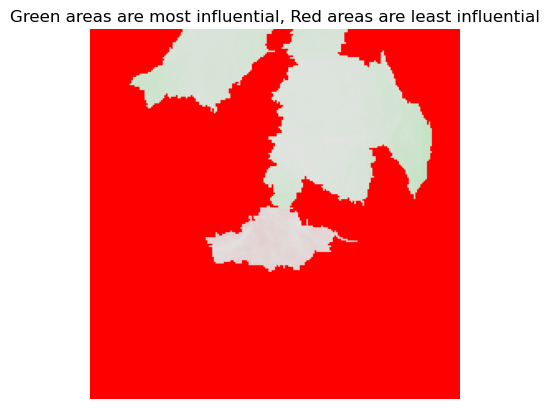

In [31]:
top_label = explanation.top_labels[0]
temp, mask = explanation.get_image_and_mask(top_label, positive_only=False, num_features=5, hide_rest=False)

# Create masks for the most and least influential areas
most_influential_mask = np.isin(mask, [8, 7, 17])
least_influential_mask = np.isin(mask, [5, 4, 0])

# Highlight the most influential areas in green and the least influential areas in red
highlighted_img = temp / 2 + 0.5  # Convert the image back to the [0, 1] range
highlighted_img[most_influential_mask] = [0, 1, 0]  # Green for most influential
highlighted_img[least_influential_mask] = [1, 0, 0]  # Red for least influential

# Display the highlighted image
plt.imshow(highlighted_img)
plt.title("Green areas are most influential, Red areas are least influential")
plt.axis('off')
plt.show()

In [32]:
################################# 

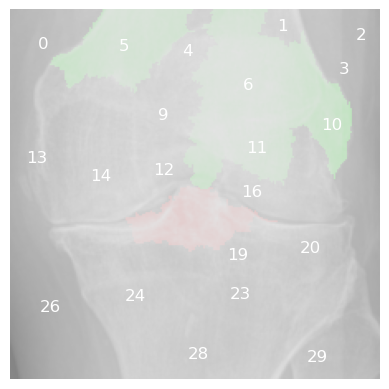

In [33]:
import numpy as np
import matplotlib.pyplot as plt

# ... (previous code)

# Fetch explanation for the top class
# Fetch the segments used in the explanation
segments = explanation.segments

# Fetch explanation for the top class
top_label = explanation.top_labels[0]
lime_output = {}
for area in explanation.local_exp[top_label]:
    lime_output[area[0]] = area[1]

# Sort areas by importance and keep only positive ones
positive_areas = [area for area, importance in sorted(lime_output.items(), key=lambda x: x[1], reverse=True) if importance > 0]

# Create an image to display
highlighted_img = temp / 2 + 0.5  # Convert the image back to the [0, 1] range

# Loop through each unique segment index
for segment_index in positive_areas:
    # Create a mask for the current segment index
    segment_mask = (segments == segment_index)
    
    # Find the centroid of this segment
    coords = np.column_stack(np.where(segment_mask))
    if coords.size == 0:
        continue
    centroid = coords.mean(axis=0)
    
    # Annotate the image with the segment index
    plt.text(centroid[1], centroid[0], str(segment_index), color='white', fontsize=12, ha='center', va='center')

# Display the image and annotations
plt.imshow(highlighted_img)
plt.axis('off')
plt.show()